In [97]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD,PCA,RandomizedPCA
from collections import Counter
import re
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as col
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline

from datetime import date, timedelta,datetime
import calendar
from isoweek import Week
import seaborn as sns
from stop_words import get_stop_words
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")


from  config import *

In [2]:
def create_content_df():    
    authors = pd.read_csv(DATA_PATH+"authors_id.csv",index_col=0)
    authors=authors[['id','displayName']]
    df = pd.read_csv(DATA_PATH+"all_content.csv")
    stop_words_en = get_stop_words('en')

    df = pd.merge(df,authors,left_on='author_id',right_on='id',how='inner')

    df=df[['displayName','content','collection_id','created_at']]
    df.columns = ['author_name','content','collection_id','created_at']
    return df

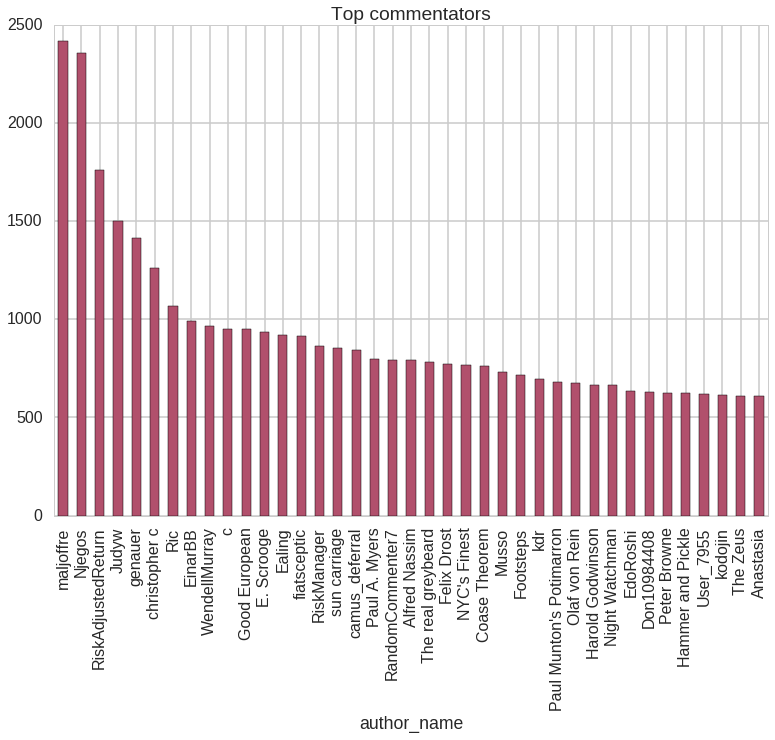

In [3]:
df = create_content_df()
groupy = df.groupby('author_name').count().sort_values(by='content',ascending=False)

groupy.content[groupy.content>600].plot(kind='bar',color=SINGLE_COLOR, title="Top commentators")

In [8]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [107]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [111]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/ramon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [136]:
def concat_content_per_author(df_content):
    groupy = df_content.groupby('author_name').count().sort_values(by='content',ascending=False)

    top_commentators =  groupy.content[groupy.content>700].index.tolist()
    top_commentators = list(set(top_commentators) - set(['genauer','c','camus_deferral']))
    df = df_content[df_content.author_name.isin(top_commentators) ]
    groupy = df.groupby('author_name')
    result = groupy.content.apply(lambda x: x.str.cat())
    result = result.apply(preprocessor)
    df_content = pd.DataFrame(result)
    
    return df_content.reset_index()  

## TFIDF to PCA

In [137]:
df_comments = concat_content_per_author(df)

In [138]:
df_comments[df_comments.author_name=='RandomCommenter7'].content.tolist()

[' a hero in greece since he humiliated the nazi occupiers by climbing up the acropolis and tearing down the swastika flag in 1941 the funny thing is no one has ever been able to find any actual historical evidence that glezos and santas removed the flag beyond their own words it s also not entirely clear that when greeks today think of glezos the first thought that comes to mind is hero but the good communist did send his kids to private school i c excuse me but where is the evidence that manolis glezos and apostolos santas removed it apart from their own words you cite newspaper reports that the flag was removed you present no evidence that it was removed by glezos and santas kalidas true but glezos supported the syriza government platform of bringing private schools in greece effectively under the control of the state so does tsipras yet surprisingly sends his own kids to a private nursery school komis why exploiting the sufferings of the greek people under nazi occupation to make a

In [139]:
data = df_comments.content.values
labels = df_comments.author_name.values
target = df_comments.index
print len(labels.tolist())

23


0.814243329718
[ 8.87198623  8.03096093  6.7975616   6.42716861  6.07730865  5.79386075
  5.53044369  5.16583262  4.80947451  4.70570107  4.34508923  4.09587891
  3.86511899  3.57936829  3.3285789 ]


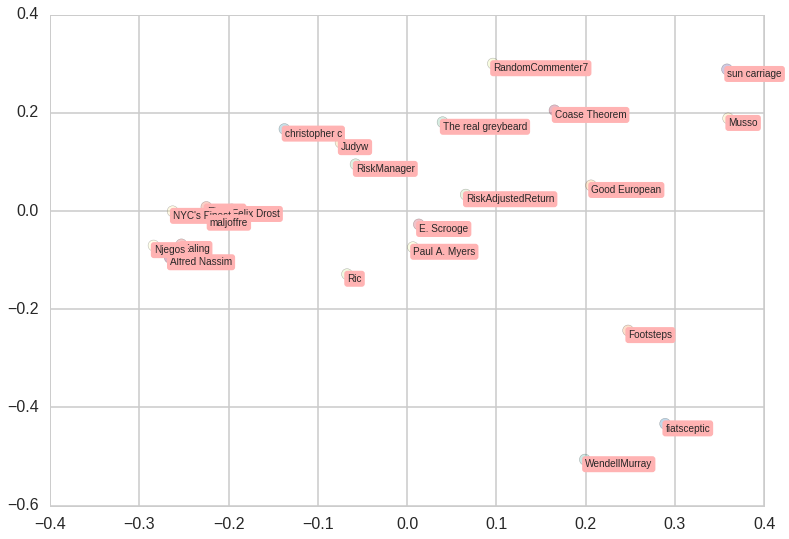

In [140]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 1),tokenizer=tokenizer_porter,stop_words=stop)),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(data).todense()

pca = PCA(n_components=15).fit(X)

print pca.explained_variance_ratio_.sum()
print pca.explained_variance_ratio_*100

cmap = cm.get_cmap('Spectral')

data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=target,cmap=cmap,s=120,edgecolors=None,alpha=0.3)


for i, txt in enumerate(labels.tolist()):
    plt.annotate(txt, (data2D[i,0]+.0003,data2D[i,1]+.0008),fontsize=10,verticalalignment='top',horizontalalignment='left',
                bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),)

## PCA with simple word count

In [6]:
def word_count(df,author_name):
    df1 = df[df.author_name==author_name]
    content =df1.content.str.cat()
    words = re.split(r'\W+', content.lower())
    words = filter(lambda x: x.isalpha(), words)
    words = [word for word in words 
    if len(word) > 3 and word not in stop_words_en]
    
    word_count = Counter(words)
    return word_count



In [7]:
author_list =['The real greybeard','Iron Knee', 'christopher c','Francheska (Maya) Smith-Johnson',
 'Njegos',
 'maljoffre',
 'Paul A. Myers',
 "Paul Munton's Potimarron",
 'TylerDurden',
 'Harold Godwinson',
 'Ealing',
 'MarkGB',
 'rrrahul',
 'Harry Lime',
 'Gulliver',
 'Good European',
 'Judyw',
 'Don10984408',
 'Apostle',
 'RiskAdjustedReturn',
 'Ric']


In [8]:
word_df = pd.DataFrame()
for author in author_list:
    word_counter = word_count(df,author)
    word_count_df = pd.DataFrame.from_dict(word_counter,
                                     orient='index')
#     file_df.columns = [fname.replace('input/papers/', '').replace('.txt', '')]
    word_count_df.ix[:, 0] = word_count_df.values.flatten() / float(word_count_df.values.sum())
    word_count_df.columns=[author]
    word_df = pd.merge(word_df,word_count_df,left_index=True,right_index=True,how='outer')

word_df = word_df.fillna(0)
print "Number of unique words: %s" % len(word_df)
word_df.head(10)

Number of unique words: 34436


,The real greybeard,Iron Knee,christopher c,Francheska (Maya) Smith-Johnson,Njegos,maljoffre,Paul A. Myers,Paul Munton's Potimarron,TylerDurden,Harold Godwinson,Ealing,MarkGB,rrrahul,Harry Lime,Gulliver,Good European,Judyw,Don10984408,Apostle,RiskAdjustedReturn,Ric
aaib,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000023,0.000000,0.00000,0.0,0.0
aamer,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000169,0.0,0.000000,0.000000,0.00000,0.0,0.0
aaron,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000018,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
aarsal,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000081,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
aawsat,0.0,0.0,0.000000,0.0,0.000031,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
aawy,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000063,0.00000,0.0,0.0
abaaoud,0.0,0.0,0.000105,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
abaaoudcould,0.0,0.0,0.000021,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
abacab,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000169,0.0,0.000000,0.000000,0.00007,0.0,0.0
aback,0.0,0.0,0.000000,0.0,0.000016,0.000022,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0


In [10]:
data =word_df.T
data.shape

(21, 34436)

In [11]:
labels = data.index.values

In [12]:
pca = TruncatedSVD(n_components=15, random_state=42)
X = pca.fit_transform(data) 
X.shape

(21, 15)

In [13]:
print pca.explained_variance_ratio_.sum()

0.879501215212


In [14]:
pca.explained_variance_ratio_*100

array([  1.71722163,  15.84768486,   9.6466103 ,   9.00473519,
         7.53182856,   6.83641765,   6.08700129,   5.21599691,
         4.80193575,   4.27968274,   4.03447024,   3.53011448,
         3.32079228,   3.10007294,   2.99555671])

In [15]:
df = pd.DataFrame({"name":labels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] =X[:,i]
df.head()

,name,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15
0,The real greybeard,0.028222,0.002714,-0.003690,-0.002311,-0.000657,-0.001621,-0.000130,0.000973,0.001333,-0.000224,0.000403,-0.003266,-0.001345,-0.003393,0.000444
1,Iron Knee,0.025721,0.014307,-0.001591,-0.000100,-0.002412,0.004808,0.015623,-0.006000,0.010955,-0.002335,-0.001175,0.002493,0.001004,-0.002113,-0.001023
2,christopher c,0.029664,-0.001348,0.000954,0.007196,0.016135,0.011144,-0.003237,-0.008010,0.001459,0.003041,0.002624,-0.001296,0.000114,0.002237,-0.000442
3,Francheska (Maya) Smith-Johnson,0.027473,0.015801,-0.000343,0.004099,-0.000781,-0.007175,0.003899,0.004064,-0.004049,0.006054,0.012681,0.000668,-0.004083,0.002469,0.001094
4,Njegos,0.024993,0.006261,0.003890,0.002063,0.002021,-0.000029,-0.003346,0.000566,-0.002167,0.002041,0.000190,-0.000328,0.000089,0.001231,-0.000863


In [16]:
print labels.tolist()

['The real greybeard', 'Iron Knee', 'christopher c', 'Francheska (Maya) Smith-Johnson', 'Njegos', 'maljoffre', 'Paul A. Myers', "Paul Munton's Potimarron", 'TylerDurden', 'Harold Godwinson', 'Ealing', 'MarkGB', 'rrrahul', 'Harry Lime', 'Gulliver', 'Good European', 'Judyw', 'Don10984408', 'Apostle', 'RiskAdjustedReturn', 'Ric']


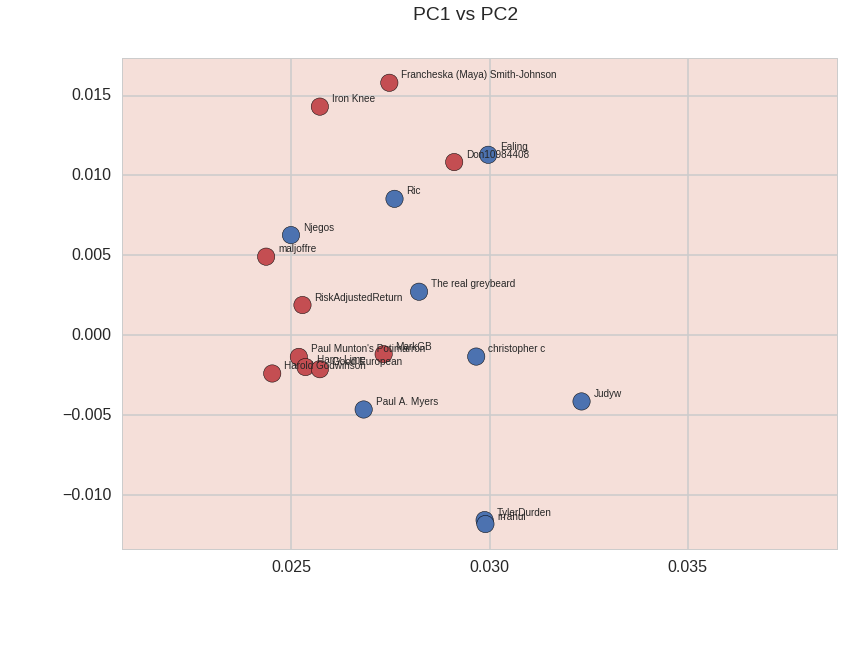

In [18]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
colors = [c0, c2]

xmin,xmax = df['pc1'].min(),df['pc1'].max()
ymin,ymax = df['pc2'].min(),df['pc2'].max()

fig, ax = plt.subplots() 
ax.set_axis_bgcolor(BACKGROUND_COLOR)
fig.suptitle("PC1 vs PC2 ")
ax.scatter(df['pc1'], df['pc2'], c=colors,s=300)
ax.set_xlim(xmin*0.9, xmax*1.1)
ax.set_ylim(ymin*0.9,ymax*1.1)



for i, txt in enumerate(labels.tolist()):
    ax.annotate(txt, (df['pc1'].iloc[i]+.0003,df['pc2'].iloc[i]+.0008),fontsize=10,verticalalignment='top',horizontalalignment='left')


(-0.02, 0.02)

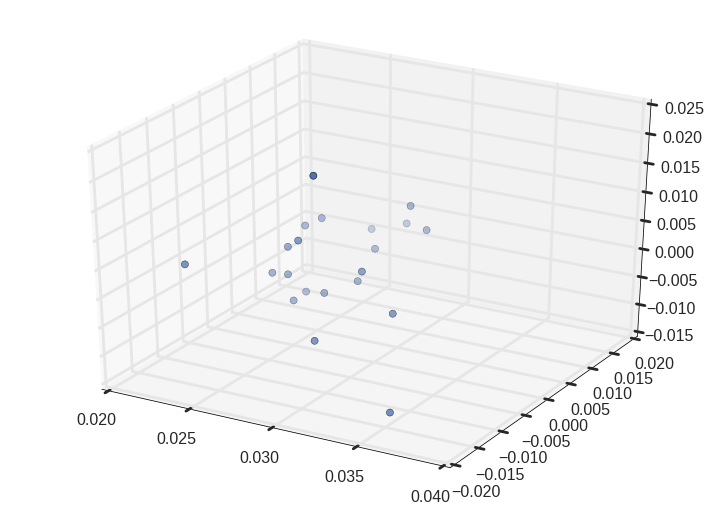

In [19]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
colors = [c0, c2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['pc1'], df['pc2'],df['pc3'], c=c0,marker='o',s=50)
ax.set_xlim(.02, .04)
ax.set_ylim(-.02, .02)


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline


newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=['alt.atheism', 'sci.space'])
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(newsgroups_train.data).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

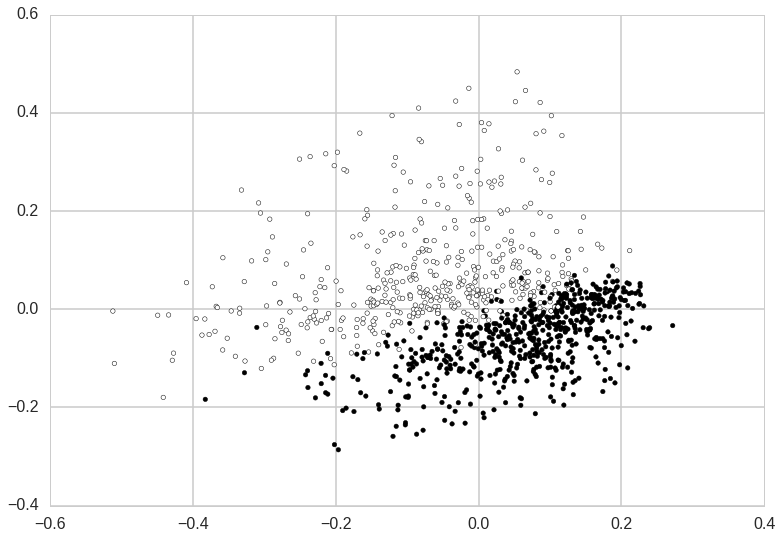

In [34]:

plt.scatter(data2D[:,0], data2D[:,1], c=newsgroups_train.target)

In [35]:
df.head()

,name,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15
0,The real greybeard,0.028222,0.002714,-0.003690,-0.002311,-0.000657,-0.001621,-0.000130,0.000973,0.001333,-0.000224,0.000403,-0.003266,-0.001345,-0.003393,0.000444
1,Iron Knee,0.025721,0.014307,-0.001591,-0.000100,-0.002412,0.004808,0.015623,-0.006000,0.010955,-0.002335,-0.001175,0.002493,0.001004,-0.002113,-0.001023
2,christopher c,0.029664,-0.001348,0.000954,0.007196,0.016135,0.011144,-0.003237,-0.008010,0.001459,0.003041,0.002624,-0.001296,0.000114,0.002237,-0.000442
3,Francheska (Maya) Smith-Johnson,0.027473,0.015801,-0.000343,0.004099,-0.000781,-0.007175,0.003899,0.004064,-0.004049,0.006054,0.012681,0.000668,-0.004083,0.002469,0.001094
4,Njegos,0.024993,0.006261,0.003890,0.002063,0.002021,-0.000029,-0.003346,0.000566,-0.002167,0.002041,0.000190,-0.000328,0.000089,0.001231,-0.000863
